#  Amazon Fine Food Reviews Analysis_XGboost

### XGboost

XGBoost is an ensemble learning method. Sometimes, it may not be sufficient to rely upon the results of just one machine learning model. Ensemble learning offers a systematic solution to combine the predictive power of multiple learners. The resultant is a single model which gives the aggregated output from several models.

## Objective:
#### To Predict the Polarity of Amazon Fine Food Review Using XGBoost Algorithm

### Importing All Required Library

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from tqdm import tqdm
import os

In [6]:
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

### Importing Amazon Fine Food Review Dataset

In [9]:
if os.path.isfile("final.sqlite"):
    conn=sqlite3.connect("final.sqlite")
    Data=pd.read_sql_query("select * from Reviews where Score!=3",conn)
    conn.close()
else :
    print("Error Importing the file")

In [10]:
# Printing some data of DataFrame

Data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

### Information About DataSet

In [11]:
print("\nNumber of Reviews: ",Data["Text"].count())
print("\nNumber of Users: ",len(Data["UserId"].unique())) # Unique returns 1-D array of unique values of DataFrame.
print("\nNumber of Products: ",len(Data["ProductId"].unique()))
print("\nShape of Data: ", Data.shape)
print("\nColumn Name of DataSet : ",Data.columns)
print("\n\nNumber of Attributes/Columns in data: 12") 
print("\nNumber of Positive Reviews : ", Data['Score'].value_counts()[1])
print("\nNumber of Negative Reviews : ", Data['Score'].value_counts()[0])


Number of Reviews:  364171

Number of Users:  243414

Number of Products:  65442

Shape of Data:  (364171, 12)

Column Name of DataSet :  Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')


Number of Attributes/Columns in data: 12

Number of Positive Reviews :  57110

Number of Negative Reviews :  307061


In [12]:
print("\nNumber of Reviews: ",Data["Text"].count())


Number of Reviews:  364171


### Attribute Information About DataSet

1.Id - A unique value starts from 1

2.ProductId - A unique identifier for the product

3.UserId - A unqiue identifier for the user

4.ProfileName - Name of user profile

5.HelpfulnessNumerator - Number of users who found the review helpful

6.HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not

7.Score - Rating 0 or 1

8.Time - Timestamp for the review

9.Summary - Brief summary of the review

10.Text - Text of the review

11.Cleaned Text - Text that only alphabets

In [13]:
# Sorting on the basis of Time Parameter
Data.sort_values('Time',inplace=True)

In [14]:
Data=Data.head(20000)

In [15]:
Y = Data['Score']
X = Data['CleanedText']

### Splitting DataSet into Train and Test Data

In [16]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase): this is for time series split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33,shuffle=False) # this is random splitting

print("Shape of Train and Test Dataset for 100k points")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

Shape of Train and Test Dataset for 100k points
(13400,) (13400,)
(6600,) (6600,)


## Hyperparameter

In [30]:
#mss =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
mss =[5,10,20,50,100]
estimate ={'max_depth' : [1,5,10,50,100,500,1000] , 'n_estimators' : mss}

In [31]:
mss

[5, 10, 20, 50, 100]

### Defining Some Function

In [32]:
#bestparameters

def findbestparameters(model,X,y,parameter = estimate):
    gs = GridSearchCV(model,param_grid = parameter , cv = 10 ,verbose=0)
    gs.fit(X,y)
    return gs

In [33]:
def train_auc_heatmap(gs):
    results = rs.cv_results_
    train = np.array(results['mean_train_score'])
    train = train.reshape(7,5)
    sns.heatmap(train,annot =True,yticklabels = [1,5,10,50,100,500,1000],xticklabels =mss,linewidths=.5,cmap="YlGnBu" )
    

In [34]:
def cv_auc_heatmap(gs):
    results = rs.cv_results_
    cv = np.array(results['mean_test_score'])
    cv = cv.reshape(7,5)
    sns.heatmap(cv,annot =True,yticklabels = [1,5,10,50,100,500,1000],xticklabels =mss,linewidths=.5 ,cmap= 'YlGnBu' )

In [35]:
#AUC curve

def depth_auc(model,X,y):
    
    md ={'max_depth' : [1,5,10,50,100,500,1000]}
    rs = findbestparameters(model,X,y,parameter = md)
    results = rs.cv_results_
    
    train = results['mean_train_score']
    print('train_score : ',train)
    
    cv = results['mean_test_score']
    print('cv_score : ',cv)
    
    max_depth = md['max_depth']
    
    plt.plot(max_depth, train, label='Train AUC')
    plt.plot(max_depth, cv, label='CV AUC')
    plt.title('Hyperparameters vs AUC plot')
    plt.xlabel('max_depth')
    plt.ylabel('mean score')
    plt.legend()
    plt.show()
    

In [1]:
#Plot ROC_AUC Curve

def plot_auc_roc(model,X_train,X_test,y_train,y_test):
    train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("hyperparameter")
    plt.ylabel("AUC")
    plt.title("ROC CURVE PLOTS")
    plt.show()

## Splitting into train and test

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size = 0.33,shuffle='false')
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(13400,) (13400,)
(6600,) (6600,)


##  BAG OF WORDS

In [39]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train)
X_test_bow = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])
print(X_train_bow.shape, y_test.shape)
print(X_test_bow.shape, y_test.shape)

some feature names  ['aa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaaaaa', 'aaaaah', 'aaaah', 'aachen', 'aafco', 'aahs', 'aap']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (33500, 34864)
the number of unique words  34864
(33500, 34864) (16500,)
(16500, 34864) (16500,)


In [45]:
tr = XGBClassifier()

### Hyperparameter tuning

In [46]:
rs = findbestparameters(tr,X_train_bow,y_train)

#### Hyperparameter - Train Score Heatmap

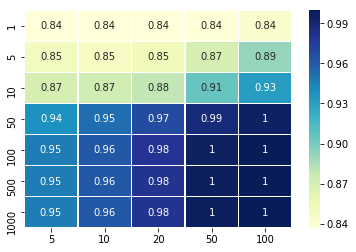

In [47]:
train_auc_heatmap(rs)

##### Hyperparameter - Cv Score Heatmap

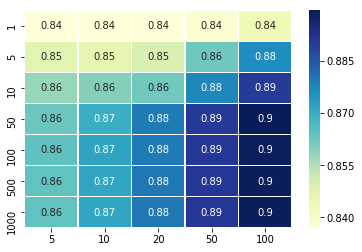

In [48]:
cv_auc_heatmap(rs)

## Best parameters

In [49]:
rs.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=50, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Training the model

In [50]:
tr =  XGBClassifier(n_estimators=100,max_depth=50,class_weight = 'balanced')

In [51]:
tr.fit(X_train_bow,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=50, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

### Confusion Matrix

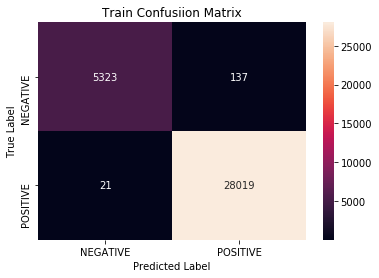

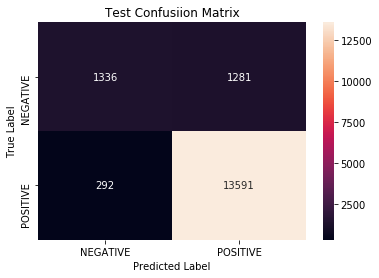

In [52]:
#ploting Confusion matrix
confusionmatix(tr,X_train_bow,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#test
confusionmatix(tr,X_test_bow,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC-AUC Curve

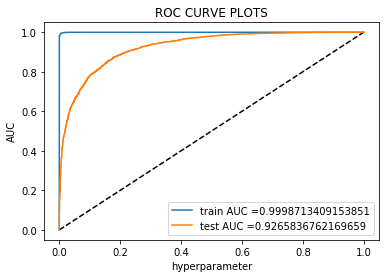

In [53]:
plot_auc_roc(tr,X_train_bow,X_test_bow,y_train,y_test)

### Classification Report

In [54]:
print("Classification Report: \n")
y_pred=tr.predict(X_test_bow)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.82      0.51      0.63      2617
           1       0.91      0.98      0.95     13883

   micro avg       0.90      0.90      0.90     16500
   macro avg       0.87      0.74      0.79     16500
weighted avg       0.90      0.90      0.90     16500



### Most important features

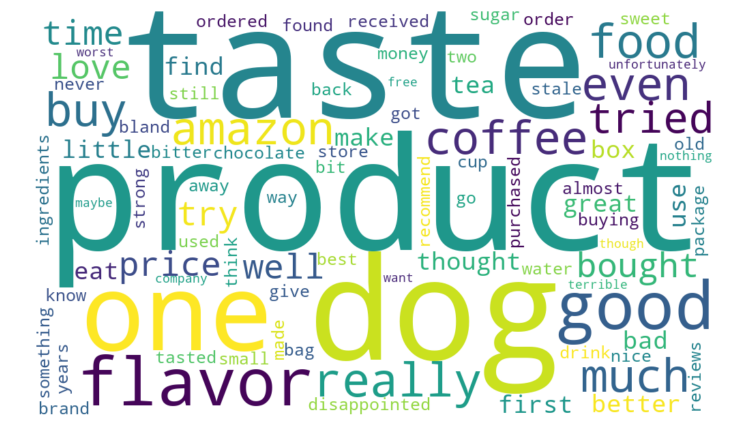

In [55]:

from wordcloud import WordCloud, STOPWORDS

features = count_vect.get_feature_names()
coef = tr.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
#plt.title("Top 100 most important features\n")
plt.tight_layout(pad = 0) 
  
plt.show()

##  TF-IDF

In [56]:
tf_idf_vect = TfidfVectorizer( min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("\nthe type of count vectorizer ",type(X_train_tfidf))
print("the shape of out text BOW vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words ", X_train_tfidf.get_shape()[1])
print()
print(X_train_tfidf.shape, y_test.shape)
print(X_test_tfidf.shape, y_test.shape)


some sample features(unique words in the corpus) ['ability', 'able', 'absence', 'absolute', 'absolutely', 'absolutly', 'absorb', 'absorbed', 'absurd', 'abundance']

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (33500, 7111)
the number of unique words  7111

(33500, 7111) (16500,)
(16500, 7111) (16500,)


In [57]:
tr = XGBClassifier(n_jobs=-1,class_weight="balanced")

### Hyperparameter Tuning

In [58]:
rs = findbestparameters(tr,X_train_tfidf,y_train)

### Hyperparameter - train score heat map

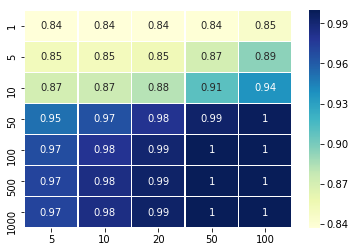

In [59]:
train_auc_heatmap(rs)

### Hyperparameter - Cv score heat map

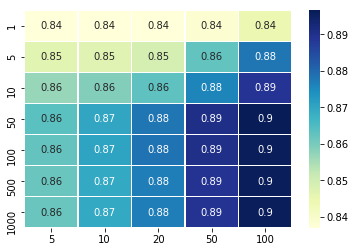

In [60]:
cv_auc_heatmap(rs)

#### Best Parameters

In [61]:
rs.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=50, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

### Training the model

In [62]:
tr =  XGBClassifier(n_estimators=100,max_depth=50,class_weight = 'balanced')

In [63]:
tr.fit(X_train_tfidf,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=50, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

### Confusion Matrix

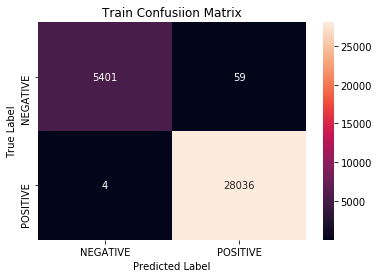

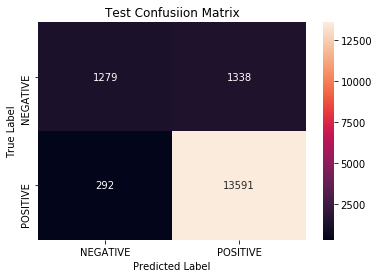

In [64]:
#ploting Confusion matrix
confusionmatix(tr,X_train_tfidf,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#test
confusionmatix(tr,X_test_tfidf,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC-Curve

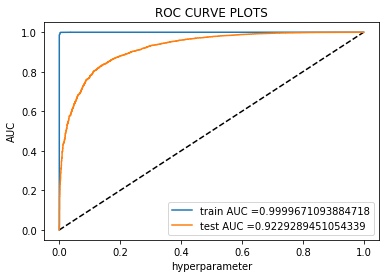

In [65]:
plot_auc_roc(tr,X_train_tfidf,X_test_tfidf,y_train,y_test)

### Classification Report

In [66]:
print("Classification Report: \n")
y_pred=tr.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.81      0.49      0.61      2617
           1       0.91      0.98      0.94     13883

   micro avg       0.90      0.90      0.90     16500
   macro avg       0.86      0.73      0.78     16500
weighted avg       0.90      0.90      0.89     16500



### Important features

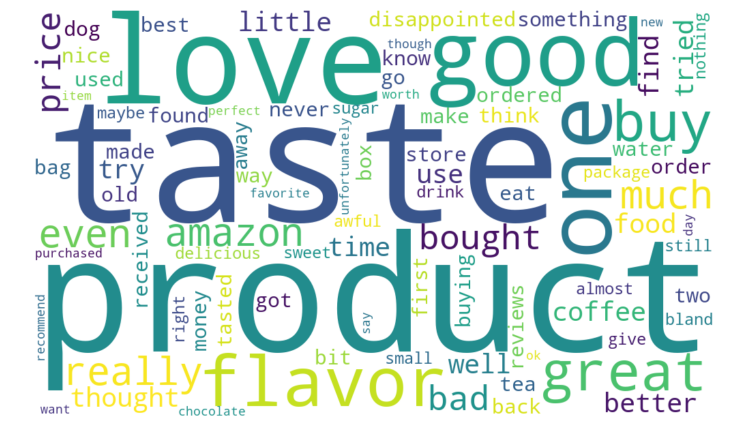

In [67]:
from wordcloud import WordCloud, STOPWORDS

features = tf_idf_vect.get_feature_names()
coef = tr.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
#plt.title("Top 100 most important features\n")
plt.tight_layout(pad = 0) 
  
plt.show()

## Word2Vec

In [55]:
i=0
list_of_train_sentance=[]
for sentance in X_train:
    list_of_train_sentance.append(sentance.split())

list_of_test_sentance=[]
for sentance in X_test:
    list_of_test_sentance.append(sentance.split())

In [56]:
w2v_model=Word2Vec(list_of_train_sentance,min_count=5,size=50, workers=4)

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [57]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  7037
sample words  ['rip', 'math', 'single', 'bag', 'stores', 'cost', 'cents', 'buy', 'adds', 'amazon', 'get', 'cheaper', 'individually', 'store', 'outrageous', 'generally', 'assume', 'everything', 'school', 'cafe', 'cheapest', 'without', 'regard', 'taste', 'however', 'tea', 'decided', 'steep', 'cup', 'extremely', 'pleasantly', 'surprised', 'excellent', 'going', 'couple', 'boxes', 'least', 'almonds', 'crispy', 'delicious', 'cocoa', 'powder', 'gives', 'nice', 'chocolate', 'flavor', 'thick', 'gummy', 'like', 'nuts']


##  Converting text into vectors using Avg W2V, TFIDF-W2V

## Avg W2v

In [58]:
# average Word2Vec
# compute average word2vec for each review.
#sent_vectors = [];
train_vectors= [];
# the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_train_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
print(len(train_vectors))
print(len(train_vectors[0]))

100%|███████████████████████████████████| 13400/13400 [00:28<00:00, 472.85it/s]


13400
50


In [59]:
# average Word2Vec
# compute average word2vec for each review.
#sent_vectors = [];
test_vectors= [];
# the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_test_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))
print(len(test_vectors[0]))

100%|█████████████████████████████████████| 6600/6600 [00:17<00:00, 385.26it/s]


6600
50


In [60]:
X_test_w2v =np.nan_to_num(test_vectors) 
X_train_w2v =np.nan_to_num(train_vectors)

In [61]:
print(X_train_w2v.shape , y_train.shape)
print(X_test_w2v.shape,y_test.shape)

(13400, 50) (13400,)
(6600, 50) (6600,)


### Hyperparameter Tuning

In [62]:
tr = XGBClassifier(n_jobs=-1,class_weight="balanced")
rs = findbestparameters(tr,X_train_w2v,y_train)

### Hyperparamter - train score heatmap

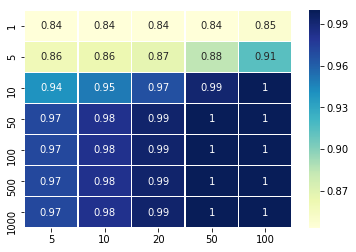

In [63]:
train_auc_heatmap(rs)

### Hyperparamter - Cv score heatmap

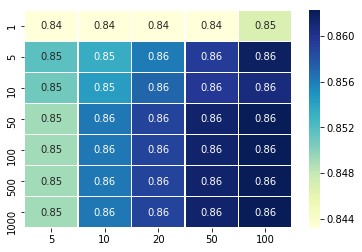

In [64]:
cv_auc_heatmap(rs)

### Best parameters

In [65]:
rs.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=50, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

### Training the model

In [66]:
tr =  XGBClassifier(n_estimators=100,max_depth=50,class_weight = 'balanced')

### Confusion Matrix

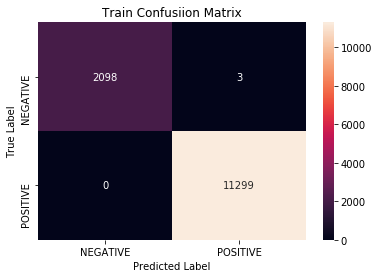

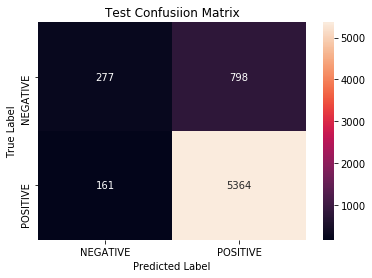

In [67]:
tr.fit(X_train_w2v,y_train)
#ploting Confusion matrix
confusionmatix(tr,X_train_w2v,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#test
confusionmatix(tr,X_test_w2v,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC-AUC Curve

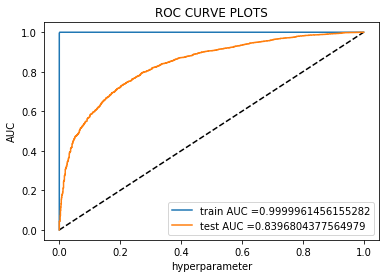

In [68]:
plot_auc_roc(tr,X_train_w2v,X_test_w2v,y_train,y_test)

### Classification report

In [69]:
print("Classification Report: \n")
y_pred=tr.predict(X_test_w2v)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.63      0.26      0.37      1075
           1       0.87      0.97      0.92      5525

   micro avg       0.85      0.85      0.85      6600
   macro avg       0.75      0.61      0.64      6600
weighted avg       0.83      0.85      0.83      6600



## TFIDF weighted W2v

In [70]:
i=0
list_of_train_sentance=[]
for sentance in X_train:
    list_of_train_sentance.append(sentance.split())

list_of_test_sentance=[]
for sentance in X_test:
    list_of_test_sentance.append(sentance.split())

In [71]:
w2v_model=Word2Vec(list_of_train_sentance,min_count=5,size=50, workers=4)

In [72]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  7037
sample words  ['rip', 'math', 'single', 'bag', 'stores', 'cost', 'cents', 'buy', 'adds', 'amazon', 'get', 'cheaper', 'individually', 'store', 'outrageous', 'generally', 'assume', 'everything', 'school', 'cafe', 'cheapest', 'without', 'regard', 'taste', 'however', 'tea', 'decided', 'steep', 'cup', 'extremely', 'pleasantly', 'surprised', 'excellent', 'going', 'couple', 'boxes', 'least', 'almonds', 'crispy', 'delicious', 'cocoa', 'powder', 'gives', 'nice', 'chocolate', 'flavor', 'thick', 'gummy', 'like', 'nuts']


In [73]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [74]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_train_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 13400/13400 [05:31<00:00, 40.47it/s]


In [44]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_test_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 6600/6600 [01:54<00:00, 57.72it/s]


In [45]:
X_test_w2v =np.nan_to_num(tfidf_sent_vectors_test) 
X_train_w2v =np.nan_to_num(tfidf_sent_vectors_train)

In [46]:
print(X_train_w2v.shape , y_train.shape)
print(X_test_w2v.shape,y_test.shape)

(13400, 50) (13400,)
(6600, 50) (6600,)


### Hyperparameter tuning

In [47]:
tr = XGBClassifier(n_jobs=-1,class_weight="balanced")
rs = findbestparameters(tr,X_train_w2v,y_train)

### Hyperparameter - train score heatmap

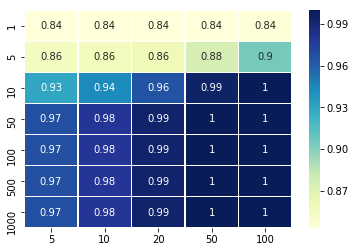

In [48]:
train_auc_heatmap(rs)

### Hyperparameter - Cv score heatmap

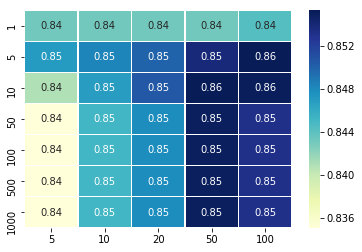

In [49]:
cv_auc_heatmap(rs)

### Best parameters

In [50]:
rs.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=50, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

### Training the model

In [51]:
tr =  XGBClassifier(n_estimators=50,max_depth=10,class_weight = 'balanced')

### Confusion Matrix

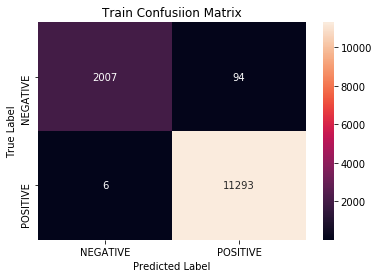

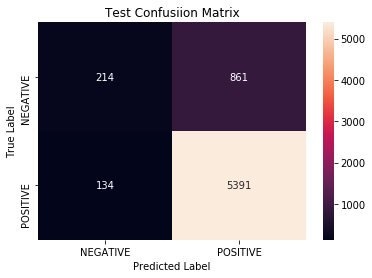

In [52]:
tr.fit(X_train_w2v,y_train)
#ploting Confusion matrix
confusionmatix(tr,X_train_w2v,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#test
confusionmatix(tr,X_test_w2v,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC-AUC Curve

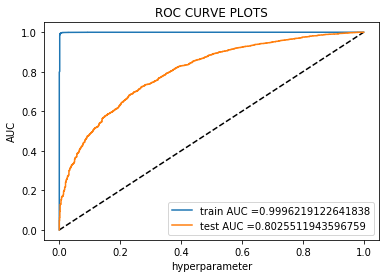

In [53]:
plot_auc_roc(tr,X_train_w2v,X_test_w2v,y_train,y_test)

### Classification report

In [54]:
print("Classification Report: \n")
y_pred=tr.predict(X_test_w2v)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.61      0.20      0.30      1075
           1       0.86      0.98      0.92      5525

   micro avg       0.85      0.85      0.85      6600
   macro avg       0.74      0.59      0.61      6600
weighted avg       0.82      0.85      0.82      6600



## Pretty table

In [75]:

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "max_depth","n_estimators","Train AUC","Test AUC","f1-Score"]

x.add_row(["Bags of Words",50,100,0.99,0.92,0.90])
x.add_row(["TF-IDF",50,100,0.99,0.91,0.89])
x.add_row(["Avg W2V",50,100,0.98,0.83,0.83])
x.add_row(["TF-IDF W2V",10,50,0.99,0.80,0.82])

print(x)

+---------------+-----------+--------------+-----------+----------+----------+
|   Vectorizer  | max_depth | n_estimators | Train AUC | Test AUC | f1-Score |
+---------------+-----------+--------------+-----------+----------+----------+
| Bags of Words |     50    |     100      |    0.99   |   0.92   |   0.9    |
|     TF-IDF    |     50    |     100      |    0.99   |   0.91   |   0.89   |
|    Avg W2V    |     50    |     100      |    0.98   |   0.83   |   0.83   |
|   TF-IDF W2V  |     10    |      50      |    0.99   |   0.8    |   0.82   |
+---------------+-----------+--------------+-----------+----------+----------+
